## Load Libraries

In [1]:
# Azure Data Lake libraries
import azure_data_lake_interface as adl

# Data analysis libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Helper function libraries
from helper_functions import load_config

## Get the Data to be Analyzed

In [2]:
# attach to the data lake
config = load_config("config/datalake_config.json", flush_cache=True)
service_client = adl.get_azure_service_client(config["blob_url"])
file_system_client = adl.get_azure_file_system_client(service_client, "consolidated")

In [3]:
# get customer and estimate data
customers = adl.get_parquet_file_from_data_lake(file_system_client, "cleaned/netsuite", "customer_cleaned.parquet")
estimates = adl.get_parquet_file_from_data_lake(file_system_client, "raw/netsuite/transaction", "Estimate_raw.parquet")

In [4]:
# change created_date to datetime and coerce all dates to datetime
estimates["created_date"] = pd.to_datetime(estimates["created_date"], errors="coerce")

# convert line item values to numeric
numerics = ['amount_paid', 'amount_unpaid', 'days_open', 'estimated_gross_profit', 'finance_charge', 'net_amount', 'total_cost_estimate']
for col in numerics:
    estimates[col] = pd.to_numeric(estimates[col], errors="coerce")

# remove all rows outside the date range
start_date = "2022-01-01"
end_date = "2025-04-14"

estimates = estimates[(estimates["created_date"] >= start_date) & (estimates["created_date"] <= end_date)]

In [5]:
customer_cols = [
    'customer_id',
    'company_name',
    'primary_sales_rep',
    'primary_service_location',
    'end_market',
    'subsidiary_name']
customer_info_subset = customers[customer_cols]

## Describe the Data

In [6]:
estimates['status'].value_counts()

status
Estimate : Processed    66937
Estimate : Expired      34456
Estimate : Closed       30468
Estimate : Open          2969
Name: count, dtype: int64

In [7]:
num_estimates = estimates.shape[0]
num_processed = estimates[estimates['status'] == 'Estimate : Processed'].shape[0]
print(f"Number of estimates: {num_estimates:,}")
print(f"Number of estimates processed: {num_processed:,}")
print(f"Percentage of estimates processed: {num_processed/num_estimates:.2%}")

Number of estimates: 134,830
Number of estimates processed: 66,937
Percentage of estimates processed: 49.65%


## Analyze the Data

In [8]:
num_estimates_by_month = estimates['created_date'].dt.to_period('M').value_counts().sort_index()
processed_estimates = estimates[estimates['status'] == 'Estimate : Processed']
num_processed_by_month = processed_estimates['created_date'].dt.to_period('M').value_counts().sort_index()
percentage_processed_by_month = (num_processed_by_month / num_estimates_by_month) * 100
value_processed_by_month = processed_estimates.groupby(processed_estimates['created_date'].dt.to_period('M'))['net_amount'].sum().sort_index()

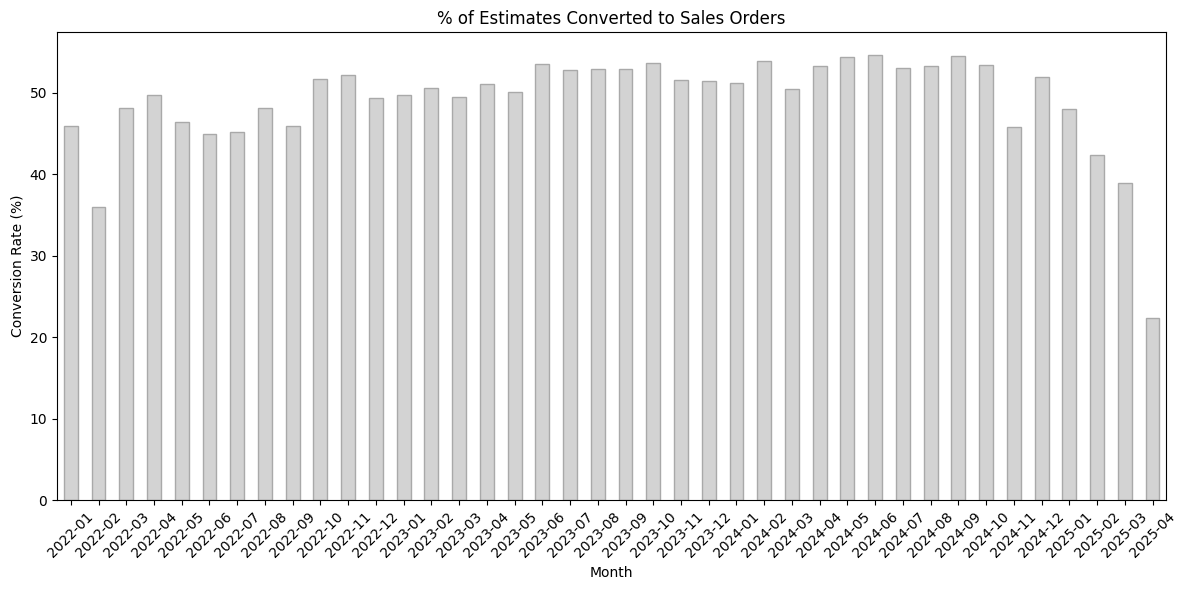

In [9]:
# Plot the % of processed estimates by month
plt.figure(figsize=(12, 6))
percentage_processed_by_month.plot(kind='bar', color='lightgray', edgecolor='darkgray')
plt.title('% of Estimates Converted to Sales Orders')
plt.xlabel('Month')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

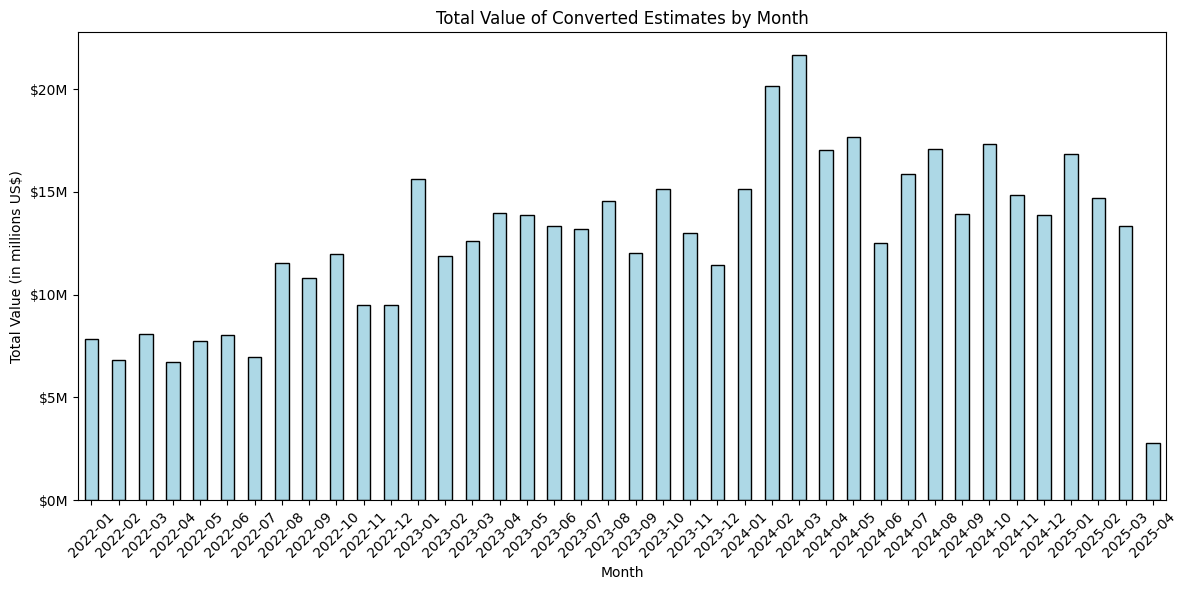

In [10]:
def money_formatter(x, pos):
    '''Format y-axis labels in millions with a dollar sign and "M".'''
    return f'${x / 1000000:,.0f}M'

# plot converted estimates by dollar value
plt.figure(figsize=(12, 6))

# Create bar plot
value_processed_by_month.plot(kind='bar', color='lightblue', edgecolor='black')

# Customize the plot
plt.title('Total Value of Converted Estimates by Month')
plt.xlabel('Month')
plt.ylabel('Total Value (in millions US$)')
plt.xticks(rotation=45)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(money_formatter))

plt.tight_layout()
plt.show()


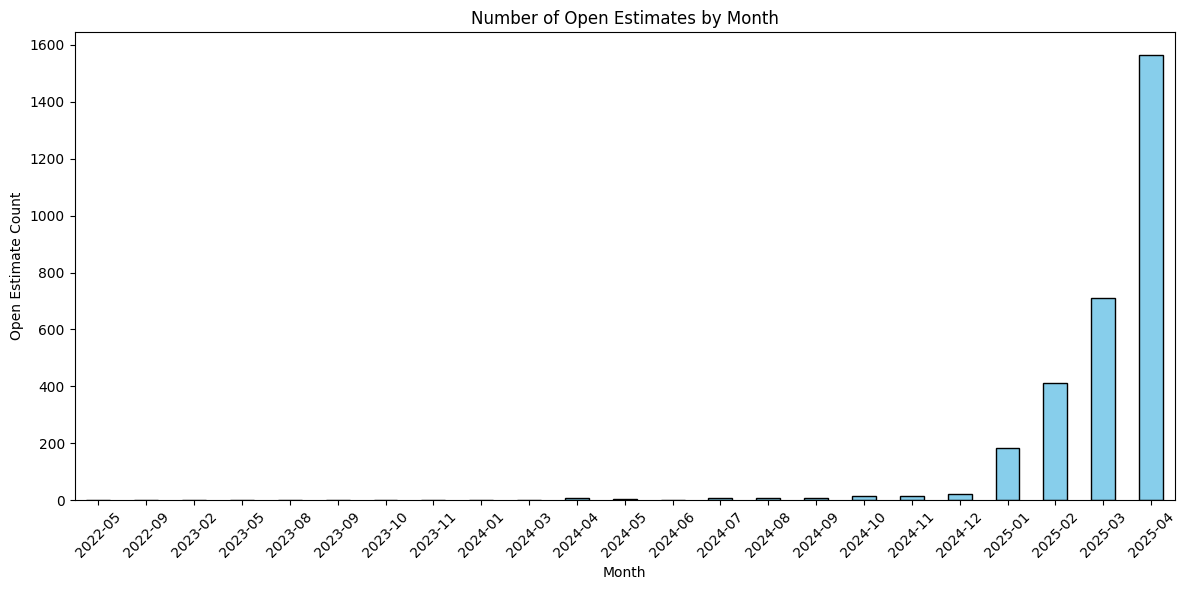

In [11]:
open_estimates = estimates[estimates['status'] == 'Estimate : Open']

# Group open estimates by transaction month
open_estimates_by_month = open_estimates['created_date'].dt.to_period('M').value_counts().sort_index()

# Plot the number of open estimates by month
plt.figure(figsize=(12, 6))
open_estimates_by_month.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Open Estimates by Month')
plt.xlabel('Month')
plt.ylabel('Open Estimate Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

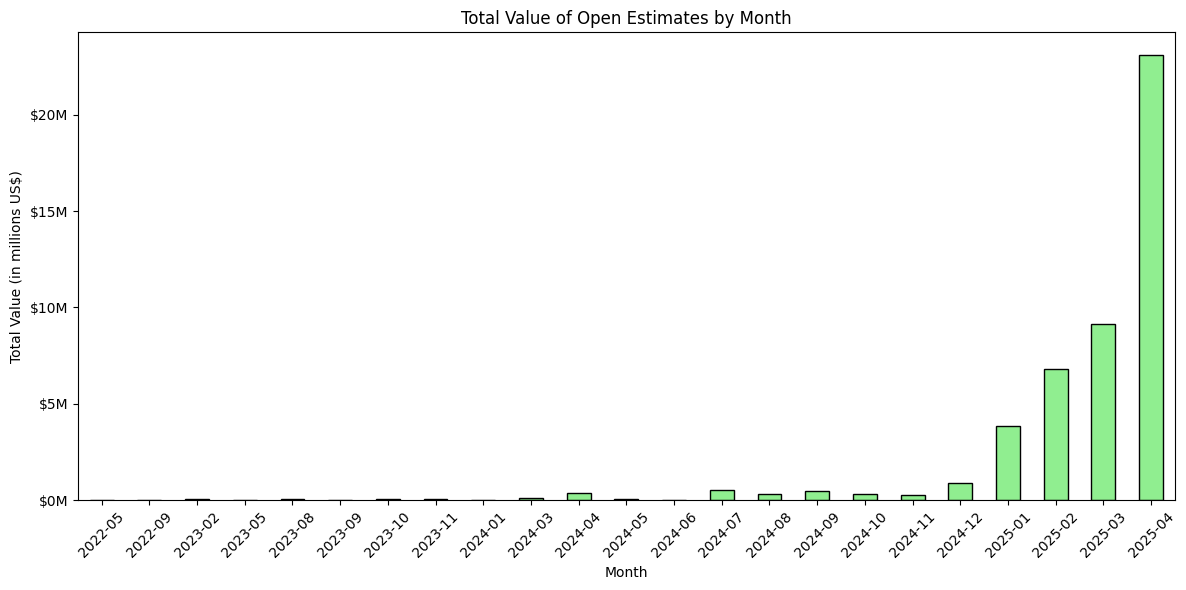

In [12]:
# display open estimates by value (net_amount)
open_estimates_by_value = open_estimates.groupby(open_estimates['created_date'].dt.to_period('M'))['net_amount'].sum().sort_index()

# Plot the total value of open estimates by month
plt.figure(figsize=(12, 6))
open_estimates_by_value.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Total Value of Open Estimates by Month')
plt.xlabel('Month')
plt.ylabel('Total Value (in millions US$)')
plt.xticks(rotation=45)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(money_formatter))

plt.tight_layout()
plt.show()

B

In [13]:
# Step 1: Create a pivot table to count each status per customer
status_counts = estimates.pivot_table(index='customer_id', columns='status', aggfunc='size', fill_value=0)

# Step 2: Calculate total orders per customer
status_counts['num_estimates'] = status_counts.sum(axis=1)

# Step 3: Calculate percentage of each status
for status in status_counts.columns[:-1]:  # Exclude 'num_estimates' column
    status_counts[f'{status} %'] = (status_counts[status] / status_counts['num_estimates']) * 100

# Step 4: Calculate sum of 'net amount' and 'gross profit' for each status per customer
status_sums = estimates.pivot_table(
    index='customer_id',
    columns='status',
    values=['net_amount', 'estimated_gross_profit'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the MultiIndex columns
status_sums.columns = [f'{status}_{metric}' for metric, status in status_sums.columns]

# Step 5: Calculate total 'net amount' and 'gross profit' across all statuses for each customer
total_sums = estimates.groupby('customer_id').agg(
    total_net_amount=('net_amount', 'sum'),
    total_gross_profit=('estimated_gross_profit', 'sum')
)

# Step 6: Merge the status counts, status sums, and total sums
final_result = pd.merge(status_counts, status_sums, on='customer_id', how='left')
final_result = pd.merge(final_result, total_sums, on='customer_id', how='left').fillna(0)

In [14]:
# Match analytics to customer name on 'customer id'
merged_data = pd.merge(final_result, customer_info_subset, on='customer_id', how='left')

In [15]:
merged_data

,customer_id,Estimate : Closed,Estimate : Expired,Estimate : Open,Estimate : Processed,num_estimates,Estimate : Closed %,Estimate : Expired %,Estimate : Open %,Estimate : Processed %,...,Estimate : Expired_net_amount,Estimate : Open_net_amount,Estimate : Processed_net_amount,total_net_amount,total_gross_profit,company_name,primary_sales_rep,primary_service_location,end_market,subsidiary_name
0,1000,10,2,0,4,16,62.500000,12.500000,0.000000,25.000000,...,8439.00,0.00,16365.00,129439.00,55384.12,Aptrade Inc,Distribution,Joliet (AV),Professional Services,Allied Valve
1,10003,0,1,3,7,11,0.000000,9.090909,27.272727,63.636364,...,302.34,12142.10,14066.76,26511.20,8777.70,"Bostik - Elk Grove Village, IL",Mark McCarthy,Joliet (AV),Chemical/Petrochem,Allied Valve
2,10013,0,1,0,2,3,0.000000,33.333333,0.000000,66.666667,...,2664.10,0.00,3622.00,6286.10,1672.40,Motion Industries - Ottumwa IA,Distribution,Riverdale (AV),Reseller/Distributer,Allied Valve
3,10016,0,0,0,3,3,0.000000,0.000000,0.000000,100.000000,...,0.00,0.00,18867.88,18867.88,17758.00,"Dynegy Kincaid Generation, LLC",Todd L White,Riverdale (AV),Power/Utilities,Allied Valve
4,10022,2,5,0,29,36,5.555556,13.888889,0.000000,80.555556,...,6999.97,0.00,76597.38,86610.35,32194.10,PQ Corporation,Distribution,Joliet (AV),Chemical/Petrochem,Allied Valve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12277,9969,1,4,0,31,36,2.777778,11.111111,0.000000,86.111111,...,16122.50,0.00,290503.99,311117.49,182115.22,Nipsco - Schahfer Station,Chad Kalecki,Joliet (AV),Power/Utilities,Allied Valve
12278,9974,7,6,0,41,54,12.962963,11.111111,0.000000,75.925926,...,26273.00,0.00,702752.09,811379.09,345052.66,Nipsco - Michigan City,Chad Kalecki,Joliet (AV),Power/Utilities,Allied Valve
12279,9983,7,19,2,12,40,17.500000,47.500000,5.000000,30.000000,...,47449.62,3290.56,68989.48,265494.35,101364.78,Macomb Group,Distribution,Joliet (AV),Reseller/Distributer,Allied Valve
12280,9985,3,15,1,15,34,8.823529,44.117647,2.941176,44.117647,...,126649.97,39.76,50460.31,296227.44,92888.09,Consolidated Pipe And Supply - Wilmington,Distribution,Joliet (AV),Reseller/Distributer,Allied Valve


In [16]:
# Save to Excel
output_file = 'analyses/estimate_counts_and_percentages_by_customer.xlsx'
merged_data.to_excel(output_file, index=False)

### Estimates by Month

In [25]:
# Step 1: Extract the transaction created month
estimates['transaction_month'] = estimates['created_date'].dt.to_period('M')

# Step 2: Calculate the transaction counts and percentages by month and status
# Get the count of transactions per status per month 
status_counts = estimates.groupby(['transaction_month', 'status']).size().unstack(fill_value=0)

# Calculate percentages for each status by month
status_percentages = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# Calculate the total number of transactions each month
transaction_counts = status_counts.sum(axis=1).rename('total_transactions')

# Step 3: Calculate the total values for "Processed" transactions for both net amount and gross profit
processed_totals = estimates[estimates['status'] == 'Estimate : Processed'].groupby('transaction_month').agg(
    processed_est_total_sales=('net_amount', 'sum'),
    processed_est_total_gross_profit=('estimated_gross_profit', 'sum')
)

# Combine status percentages, processed totals, and transaction counts into one DataFrame
result = pd.concat([status_percentages, processed_totals, transaction_counts], axis=1)

In [26]:
# imporve column names
result.index.name = "Month Created"
result = result.rename(columns={
    'Closed': '% Closed',
    'Expired': '% Expired',
    'Processed': '% Processed',
    'Open': '% Open',
    'total_transactions': 'Total Transactions',
    'processed_est_total_sales': 'Est Tot Sales (Processed Only)',
    'processed_est_total_gross_profit': 'Est Tot Gross Profit (Processed Only)'
})

# move Total Transactions to the first column
cols = result.columns.tolist()
cols = cols[-1:] + cols[:-1]
result = result[cols]

In [27]:
result

,Total Transactions,Estimate : Closed,Estimate : Expired,Estimate : Open,Estimate : Processed,Est Tot Sales (Processed Only),Est Tot Gross Profit (Processed Only)
Month Created,,,,,,,
2022-01,1891,48.228451,5.869910,0.000000,45.901639,7846614.89,3308225.69
2022-02,2353,60.220994,3.824904,0.000000,35.954101,6836773.88,3034950.08
2022-03,2137,46.326626,5.474965,0.000000,48.198409,8070254.72,3385774.05
2022-04,1829,43.685074,6.506288,0.000000,49.808639,6731647.09,2923857.32
2022-05,2052,40.058480,13.499025,0.048733,46.393762,7716723.81,3099286.43
2022-06,2495,36.553106,18.476954,0.000000,44.969940,8055825.29,3123150.75
2022-07,2408,29.568106,25.249169,0.000000,45.182724,6962730.79,2700944.08
2022-08,2884,31.657420,20.145631,0.000000,48.196949,11515736.68,4136854.62
2022-09,3330,24.714715,29.339339,0.030030,45.915916,10796030.77,4084183.97


In [28]:
# Save to Excel
output_file = 'analyses/estimate_percentages_by_month.xlsx'
result.to_excel(output_file, index=True)

### Estimates by Entered By

In [29]:
# 1. Total number of transactions entered by each person
total_transactions = estimates.groupby('entered_by').size().rename("total_transactions")

# 2. Percentages of transactions in each status category by person
status_counts = estimates.groupby(['entered_by', 'status']).size().unstack(fill_value=0)
status_percentages = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# 3. Total net amount and gross profit for 'Processed' transactions entered by each person
processed_totals = estimates[estimates['status'] == 'Estimate : Processed'].groupby('entered_by').agg(
    total_net_amount=('net_amount', 'sum'),
    total_gross_profit=('estimated_gross_profit', 'sum')
)

# Combine the results
result = total_transactions.to_frame().join(status_percentages).join(processed_totals)

In [30]:
# imporve column names
result = result.rename(columns={
    'Closed': '% Closed',
    'Expired': '% Expired',
    'Processed': '% Processed',
    'Open': '% Open',
    'total_transactions': 'Total Transactions',
    'total_net_amount': 'Est Tot Sales (Processed Only)',
    'total_gross_profit': 'Est Tot Gross Profit (Processed Only)'
})

In [31]:
result

,Total Transactions,Estimate : Closed,Estimate : Expired,Estimate : Open,Estimate : Processed,Est Tot Sales (Processed Only),Est Tot Gross Profit (Processed Only)
entered_by,,,,,,,
(AI) House,2,0.000000,100.000000,0.000000,0.000000,NaN,NaN
ASIS Integration,18332,87.535457,6.665939,5.798604,0.000000,NaN,NaN
Aaron Leake,14,0.000000,42.857143,0.000000,57.142857,195238.07,55542.65
Aaron Lutton,393,0.000000,52.417303,4.325700,43.256997,950963.60,416162.33
Adrianne Payne,8,0.000000,0.000000,0.000000,100.000000,150135.38,96208.50
...,...,...,...,...,...,...,...
Venice Elumbaring,1717,2.620850,0.465929,0.524170,96.389051,4278377.10,2582505.04
Wanda Dolan,161,9.937888,4.347826,0.000000,85.714286,838219.30,486958.17
William Wingard Sr.,449,49.665924,0.668151,0.222717,49.443207,2228846.26,628426.67


In [32]:
# Save to Excel
output_file = 'analyses/estimate_percentages_by_who_entered_them.xlsx'
result.to_excel(output_file, index=True)

### Estimates by Sales Rep

In [33]:
# merge data from customers to get sales rep name
estimates = pd.merge(estimates, customer_info_subset, on='customer_id', how='left')

In [34]:
# Replace empty string values in 'primary sales rep' with "Not Specified"
estimates.replace({'primary_sales_rep': {"": "Not Specified"}}, inplace=True)

In [35]:
# 1. Total number of transactions entered by each person
total_transactions = estimates.groupby('primary_sales_rep').size().rename("total_transactions")

# 2. Percentages of transactions in each status category by person
status_counts = estimates.groupby(['primary_sales_rep', 'status']).size().unstack(fill_value=0)
status_percentages = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# 3. Total net amount and gross profit for 'Processed' transactions entered by each person
processed_totals = estimates[estimates['status'] == 'Estimate : Processed'].groupby('primary_sales_rep').agg(
    total_net_amount=('net_amount', 'sum'),
    total_gross_profit=('estimated_gross_profit', 'sum')
)

# Combine the results
result = total_transactions.to_frame().join(status_percentages).join(processed_totals)

In [36]:
# imporve column names
result = result.rename(columns={
    'Closed': '% Closed',
    'Expired': '% Expired',
    'Processed': '% Processed',
    'Open': '% Open',
    'total_transactions': 'Total Transactions',
    'total_net_amount': 'Est Tot Sales (Processed Only)',
    'total_gross_profit': 'Est Tot Gross Profit (Processed Only)'
})

In [37]:
result

,Total Transactions,Estimate : Closed,Estimate : Expired,Estimate : Open,Estimate : Processed,Est Tot Sales (Processed Only),Est Tot Gross Profit (Processed Only)
primary_sales_rep,,,,,,,
(AI) House,993,0.805639,49.647533,3.121853,46.424975,4138530.42,1601609.91
(AS) HOUSE,131,90.839695,6.106870,3.053435,0.000000,NaN,NaN
(AS) House A,775,84.774194,9.290323,5.935484,0.000000,NaN,NaN
(AS) House AI,168,69.047619,14.880952,16.071429,0.000000,NaN,NaN
(AS) House I,2740,88.321168,9.051095,2.627737,0.000000,NaN,NaN
...,...,...,...,...,...,...,...
Tyler Shanteau,2942,6.220258,39.225017,1.631543,52.923182,11642791.92,4857163.48
Will Sjobeck,44,0.000000,61.363636,2.272727,36.363636,144315.59,43313.86
William O'Brien,66,1.515152,51.515152,3.030303,43.939394,178488.01,47302.13


In [38]:
# Save to Excel
output_file = 'analyses/estimate_percentages_by_sales_rep.xlsx'
result.to_excel(output_file, index=True)